In [170]:
import kagglehub
path = kagglehub.dataset_download("chadwambles/supermarket-sales")
print("Path to dataset files:", path)

Path to dataset files: /home/vadim/.cache/kagglehub/datasets/chadwambles/supermarket-sales/versions/4


In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


df = pd.read_csv('sales.csv')
df = df.drop('sale_id', axis=1)

data_quality_report = {}

In [172]:
#Stats 

data_quality_report['count'] = df.count()
data_quality_report['count_distinct'] = df.nunique()

data_quality_report['null_count'] = df.isnull().sum()
data_quality_report['not_null_count'] = df.notnull().sum()

string_columns = df.select_dtypes(include=['object']).columns
data_quality_report['length_max'] = df[string_columns].apply(lambda x: x.str.len().max() if x.dtype == "object" else np.nan)
data_quality_report['length_min'] = df[string_columns].apply(lambda x: x.str.len().min() if x.dtype == "object" else np.nan)
data_quality_report['length_avg'] = df[string_columns].apply(lambda x: x.str.len().mean() if x.dtype == "object" else np.nan)

data_quality_report['max'] = df.max(numeric_only=True)
data_quality_report['min'] = df.min(numeric_only=True)
data_quality_report['avg'] = df.mean(numeric_only=True)
data_quality_report['percentiles_25'] = df.quantile(0.25, numeric_only=True)
data_quality_report['percentiles_50'] = df.quantile(0.50, numeric_only=True)
data_quality_report['percentiles_75'] = df.quantile(0.75, numeric_only=True)
data_quality_report['stddev'] = df.std(numeric_only=True)

In [173]:
def calculate_psi(df, buckets=10): 
    psi_values = []
    for column in df.select_dtypes(include=[np.number]).columns:
        sorted_data = df[column].dropna().sort_values()
        if len(sorted_data) < 2:
            print(f"Skipping {column}: insufficient data ({len(sorted_data)} values)")
            continue
        
        split_index = len(sorted_data) // 2
        reference = sorted_data.iloc[:split_index]
        monitored = sorted_data.iloc[split_index:]
        
        if reference.min() == reference.max() or monitored.min() == monitored.max():
            print(f"Setting PSI to 0 for {column}: min == max (reference: {reference.min()}, monitored: {monitored.min()})")
            psi_values.append((column, 0.0))
            continue
        
        full_dataset = np.concatenate((reference, monitored))
        try:
            _, bin_edges = np.histogram(full_dataset, bins=buckets)
        except ValueError as e:
            print(f"Error creating histogram for {column}: {e}")
            continue
        
        reference_hist, _ = np.histogram(reference, bins=bin_edges)
        monitored_hist, _ = np.histogram(monitored, bins=bin_edges)
        
        reference_proportions = reference_hist / (np.sum(reference_hist) + 1e-6)
        monitored_proportions = monitored_hist / (np.sum(monitored_hist) + 1e-6)
        
        reference_proportions = np.where(reference_proportions == 0, 1e-6, reference_proportions)
        monitored_proportions = np.where(monitored_proportions == 0, 1e-6, monitored_proportions)
        
        psi_values_col = (monitored_proportions - reference_proportions) * np.log(monitored_proportions / reference_proportions)
        psi = np.sum(psi_values_col)
        
        if np.isnan(psi):
            print(f"PSI is NaN for {column}: reference_hist={reference_hist}, monitored_hist={monitored_hist}, bin_edges={bin_edges}")
        else:
            print(f"Calculated PSI for {column}: {psi}")
            psi_values.append((column, psi))
    
    psi_df = pd.DataFrame(psi_values, columns=['Column', 'PSI'])
    print("\nPSI DataFrame:")
    print(psi_df)

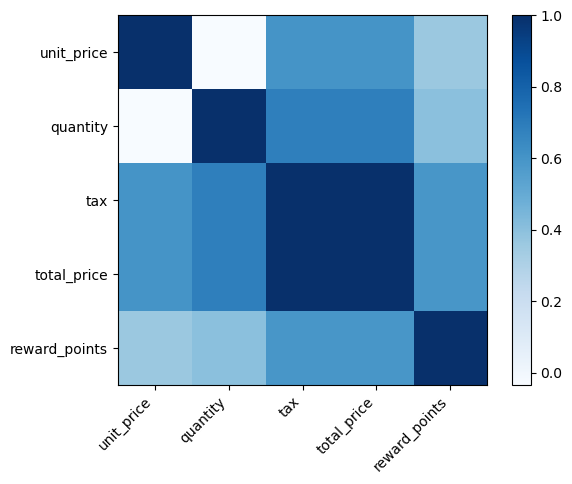

In [174]:
# Corr matrix

matrix = df.corr(numeric_only=True)
plt.imshow(matrix, cmap='Blues')
plt.colorbar()
variables = []
for i in matrix.columns:
    variables.append(i)
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)
plt.show()


array([[<Axes: title={'center': 'unit_price'}>,
        <Axes: title={'center': 'quantity'}>],
       [<Axes: title={'center': 'tax'}>,
        <Axes: title={'center': 'total_price'}>],
       [<Axes: title={'center': 'reward_points'}>, <Axes: >]],
      dtype=object)

<Figure size 640x480 with 0 Axes>

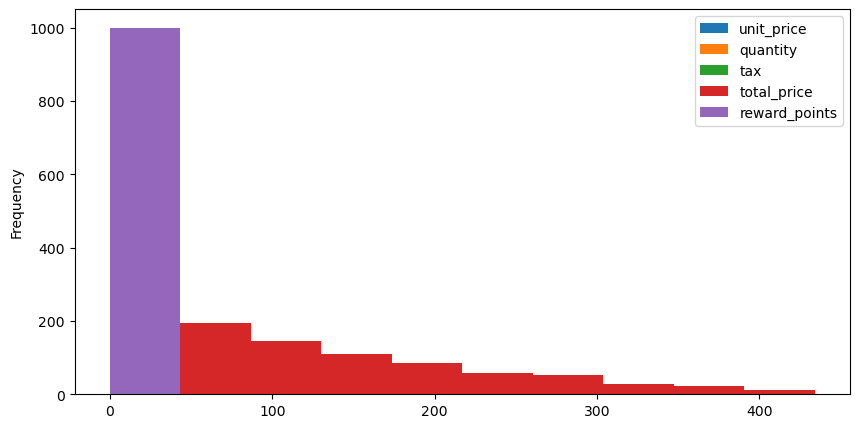

<Figure size 640x480 with 0 Axes>

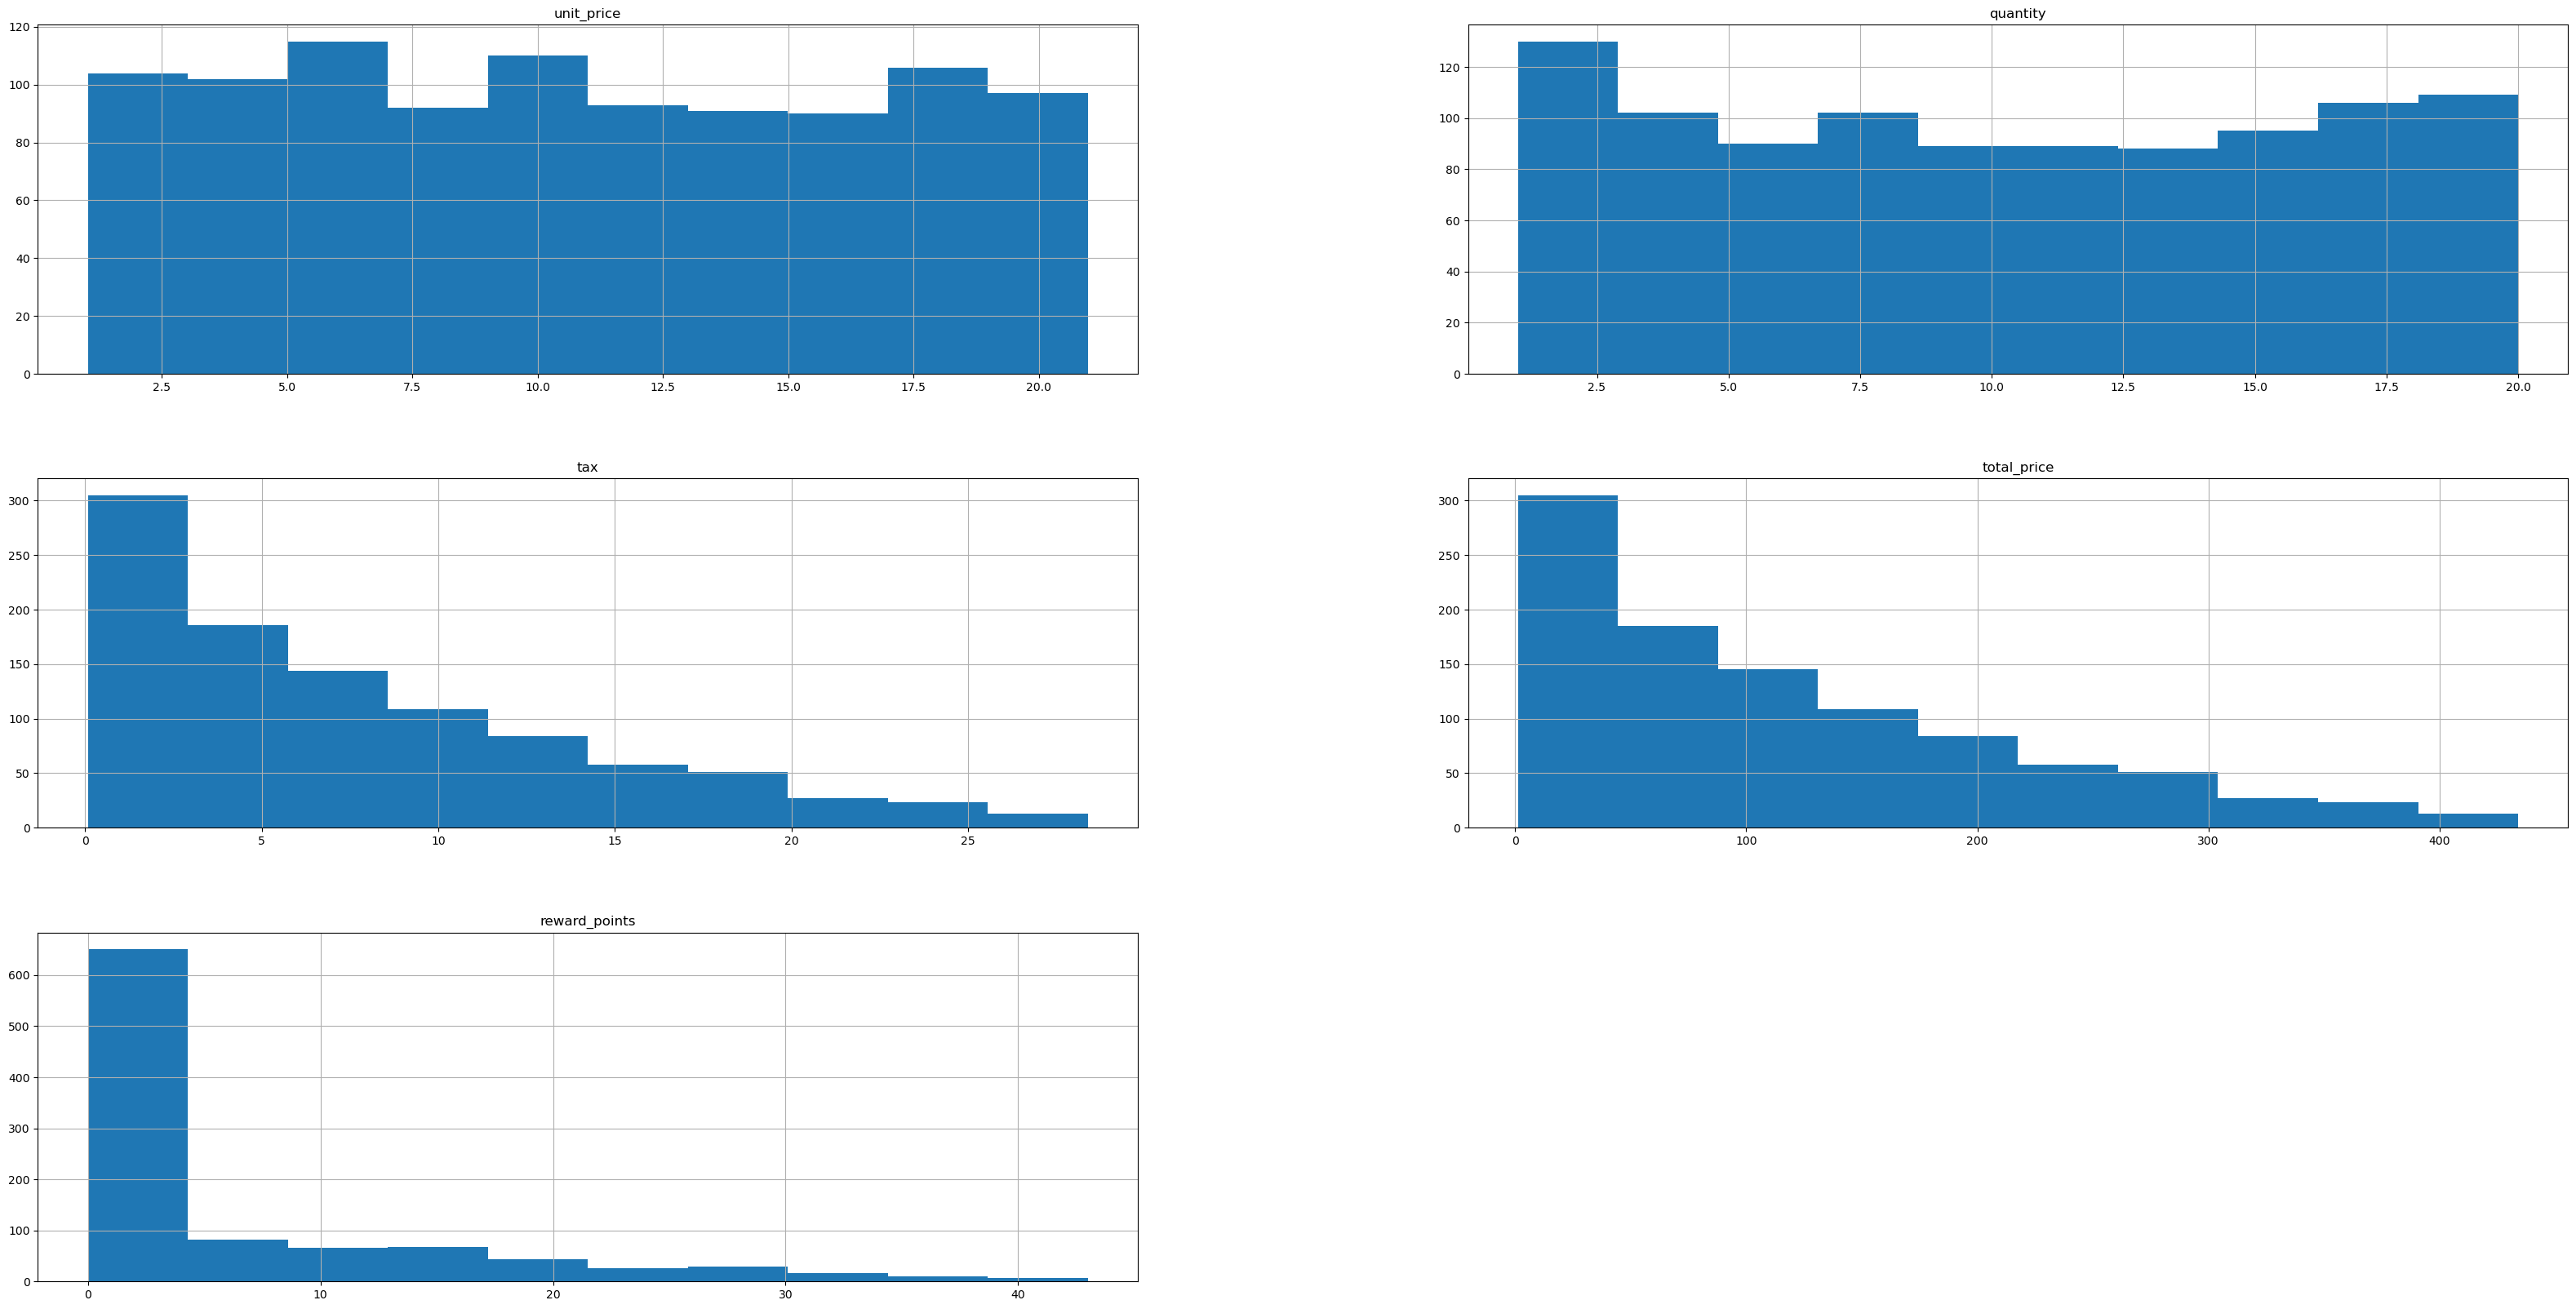

In [175]:
plt.figure()
df.plot.hist(figsize=(10, 5))
plt.figure()
df.hist(figsize=(40, 20))

In [176]:
#Output stat

report_data = []
metrics = [
    ('Count', data_quality_report['count']),
    ('Count Distinct', data_quality_report['count_distinct']),
    ('Null Count', data_quality_report['null_count']),
    ('Not Null Count', data_quality_report['not_null_count']),
    ('Length Max', data_quality_report['length_max']),
    ('Length Min', data_quality_report['length_min']),
    ('Length Avg', data_quality_report['length_avg']),
    ('Max', data_quality_report['max']),
    ('Min', data_quality_report['min']),
    ('Avg', data_quality_report['avg']),
    ('25%', data_quality_report['percentiles_25']),
    ('50%', data_quality_report['percentiles_50']),
    ('75%', data_quality_report['percentiles_75']),
    ('Stddev', data_quality_report['stddev'])
    ]

for metric_name, metric_values in metrics:
    row = {'Metric': metric_name}
    for col in df.columns:
        value = metric_values.get(col, np.nan)
        row[col] = value
    report_data.append(row)

report_df = pd.DataFrame(report_data)
report_df.set_index('Metric', inplace=True)


print(report_df)

                branch      city  customer_type    gender  product_name  \
Metric                                                                    
Count           1000.0  1000.000         1000.0  1000.000      1000.000   
Count Distinct     2.0     3.000            2.0     2.000         5.000   
Null Count         0.0     0.000            0.0     0.000         0.000   
Not Null Count  1000.0  1000.000         1000.0  1000.000      1000.000   
Length Max         1.0    11.000            6.0     6.000        12.000   
Length Min         1.0     7.000            6.0     4.000         5.000   
Length Avg         1.0     8.648            6.0     4.944         8.242   
Max                NaN       NaN            NaN       NaN           NaN   
Min                NaN       NaN            NaN       NaN           NaN   
Avg                NaN       NaN            NaN       NaN           NaN   
25%                NaN       NaN            NaN       NaN           NaN   
50%                NaN   

In [177]:
# topX

for column in df.columns:
    top_values = df[column].value_counts(dropna=False).head(5)
    top_values_list = [f"{value}: {count}" for value, count in top_values.items()]
    print(f"{column}: {top_values_list}")


branch: ['A: 674', 'B: 326']
city: ['New York: 344', 'Chicago: 330', 'Los Angeles: 326']
customer_type: ['Member: 516', 'Normal: 484']
gender: ['Male: 528', 'Female: 472']
product_name: ['Shampoo: 224', 'Orange Juice: 208', 'Notebook: 194', 'Detergent: 189', 'Apple: 185']
product_category: ['Fruits: 209', 'Personal Care: 208', 'Stationery: 198', 'Household: 198', 'Beverages: 187']
unit_price: ['17.25: 5', '11.33: 4', '1.09: 4', '10.77: 4', '8.39: 3']
quantity: ['2: 73', '18: 58', '19: 57', '1: 57', '16: 53']
tax: ['4.59: 5', '2.72: 5', '1.43: 5', '2.9: 5', '0.71: 4']
total_price: ['60.67: 3', '82.82: 2', '156.17: 2', '148.94: 2', '17.07: 2']
reward_points: ['0: 507', '1: 45', '2: 38', '4: 36', '6: 26']
